#### O objetivo deste notebook é servir como um template a ser alterado para este problema de regressão. O intuito é verificar e estudar o funcionamento básico do modelo de regressão linear. Em seguida, fazer modificações no notebook para aperfeiçoa-lo, pesquisando as alternativas existentes em cada seção (tratamento, seleção, modelo, etc), de modo a obter métricas melhores que este modelo de base.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import mutual_info_regression

import warnings
warnings.filterwarnings("ignore")

In [ ]:
import shap

In [ ]:
df = pd.read_csv("./synthetic_coffee_health_10000.csv")

# Separação Treino e Teste
Vamos separar 20% dos dados ao acaso para testar se o modelo performa bem em dados não vistos.

O conjunto de Teste deve ser tratado como algo desconhecido, portanto **não deve ser usado** nas etapas de análise/treinamento, nem para tomada de decisões quanto ao tratamento dos dados.

In [ ]:
df_train, df_test = train_test_split(df, test_size = 0.2, random_state = 42)

### Para este projeto, vamos tentar prever a média diária de horas de sono com base nas demais informações

# Triagem dos dados
Checando datatype, duplicatas e dados faltantes

In [ ]:
df_train.head()

ID  Age  Gender      Country  Coffee_Intake  Caffeine_mg  Sleep_Hours  \
9254  9255   37    Male        Spain            4.3        405.6          5.4   
1561  1562   26    Male        India            0.0          0.0          5.5   
1670  1671   32    Male  South Korea            2.8        268.1          7.3   
6087  6088   18    Male  South Korea            2.2        208.6          8.1   
6669  6670   43  Female           UK            2.6        251.1          9.4   

     Sleep_Quality   BMI  Heart_Rate Stress_Level  Physical_Activity_Hours  \
9254          Fair  18.0          86       Medium                      2.4   
1561          Fair  28.3          75       Medium                     10.8   
1670          Good  27.4          69          Low                      8.6   
6087     Excellent  16.3          83          Low                      8.9   
6669     Excellent  25.4          68          Low                      3.4   

     Health_Issues Occupation  Smoking  Alcohol_Consumption  
9254          Mild    Service        0                    1  
1561          Mild      Other        0                    0  
1670           NaN     Office        0                    0  
6087           NaN      Other        0                    1  
6669           NaN     Office        0                    0

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8000 entries, 9254 to 7270
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       8000 non-null   int64  
 1   Age                      8000 non-null   int64  
 2   Gender                   8000 non-null   object 
 3   Country                  8000 non-null   object 
 4   Coffee_Intake            8000 non-null   float64
 5   Caffeine_mg              8000 non-null   float64
 6   Sleep_Hours              8000 non-null   float64
 7   Sleep_Quality            8000 non-null   object 
 8   BMI                      8000 non-null   float64
 9   Heart_Rate               8000 non-null   int64  
 10  Stress_Level             8000 non-null   object 
 11  Physical_Activity_Hours  8000 non-null   float64
 12  Health_Issues            3277 non-null   object 
 13  Occupation               8000 non-null   object 
 14  Smoking                  8

In [ ]:
df_train.duplicated().sum()

np.int64(0)

In [ ]:
df_train.isna().sum()

ID                            0
Age                           0
Gender                        0
Country                       0
Coffee_Intake                 0
Caffeine_mg                   0
Sleep_Hours                   0
Sleep_Quality                 0
BMI                           0
Heart_Rate                    0
Stress_Level                  0
Physical_Activity_Hours       0
Health_Issues              4723
Occupation                    0
Smoking                       0
Alcohol_Consumption           0
dtype: int64

# Análise Exploratória

In [ ]:
df_train.nunique()

ID                         8000
Age                          59
Gender                        3
Country                      20
Coffee_Intake                77
Caffeine_mg                3896
Sleep_Hours                  71
Sleep_Quality                 4
BMI                         216
Heart_Rate                   57
Stress_Level                  3
Physical_Activity_Hours     151
Health_Issues                 3
Occupation                    5
Smoking                       2
Alcohol_Consumption           2
dtype: int64

In [ ]:
# possível divergência entre o número de classes reportado no dicionário e o observado (nan)
df_train['Health_Issues'].unique()

array(['Mild', nan, 'Moderate', 'Severe'], dtype=object)

In [ ]:
df_train['Health_Issues'].value_counts()

Health_Issues
Mild        2885
Moderate     380
Severe        12
Name: count, dtype: int64

In [ ]:
df_train['Health_Issues'].isna().sum()

np.int64(4723)

Muitos dados nulos nessa coluna, opções:
1. Imputação. Como essa variável é categórica não dá para usar média/mediana da coluna; é possível pensar em substituir pela categoria mais comum ou tentar replicar a distribuição observada das categorias, Outra alternativa consiste apenas em pensar nessa coluna como se fosse a variável resposta de um problema de classificação, ou seja, usar as variáveis explicativas para tentar prever a classe. (relativamente simples)

2. Se não for crucial, não use a coluna (simples)

3. Deletar as linhas **não** é uma opção. Isto acabaria com mais da metade do dataset

#### Variáveis numéricas

In [ ]:
# Descritiva
cols_numericas = ['Age', 'Coffee_Intake', 'Caffeine_mg', 'Sleep_Hours', 'BMI',
                  'Heart_Rate', 'Physical_Activity_Hours', 'Smoking', 'Alcohol_Consumption']
colunas_num = df_train[cols_numericas]
colunas_num.describe()

Age  Coffee_Intake  Caffeine_mg  Sleep_Hours          BMI  \
count  8000.000000    8000.000000  8000.000000  8000.000000  8000.000000   
mean     35.006750       2.514262   238.885325     6.629337    23.974988   
std      11.159862       1.447519   137.502461     1.225971     3.928312   
min      18.000000       0.000000     0.000000     3.000000    15.000000   
25%      27.000000       1.500000   139.900000     5.800000    21.300000   
50%      35.000000       2.500000   236.900000     6.600000    24.000000   
75%      43.000000       3.500000   332.600000     7.500000    26.700000   
max      80.000000       7.800000   742.200000    10.000000    37.900000   

        Heart_Rate  Physical_Activity_Hours      Smoking  Alcohol_Consumption  
count  8000.000000              8000.000000  8000.000000          8000.000000  
mean     70.679000                 7.464075     0.197250             0.303375  
std       9.802409                 4.303706     0.397948             0.459745  
min      50.000000                 0.000000     0.000000             0.000000  
25%      64.000000                 3.700000     0.000000             0.000000  
50%      71.000000                 7.500000     0.000000             0.000000  
75%      77.000000                11.200000     0.000000             1.000000  
max     109.000000                15.000000     1.000000             1.000000

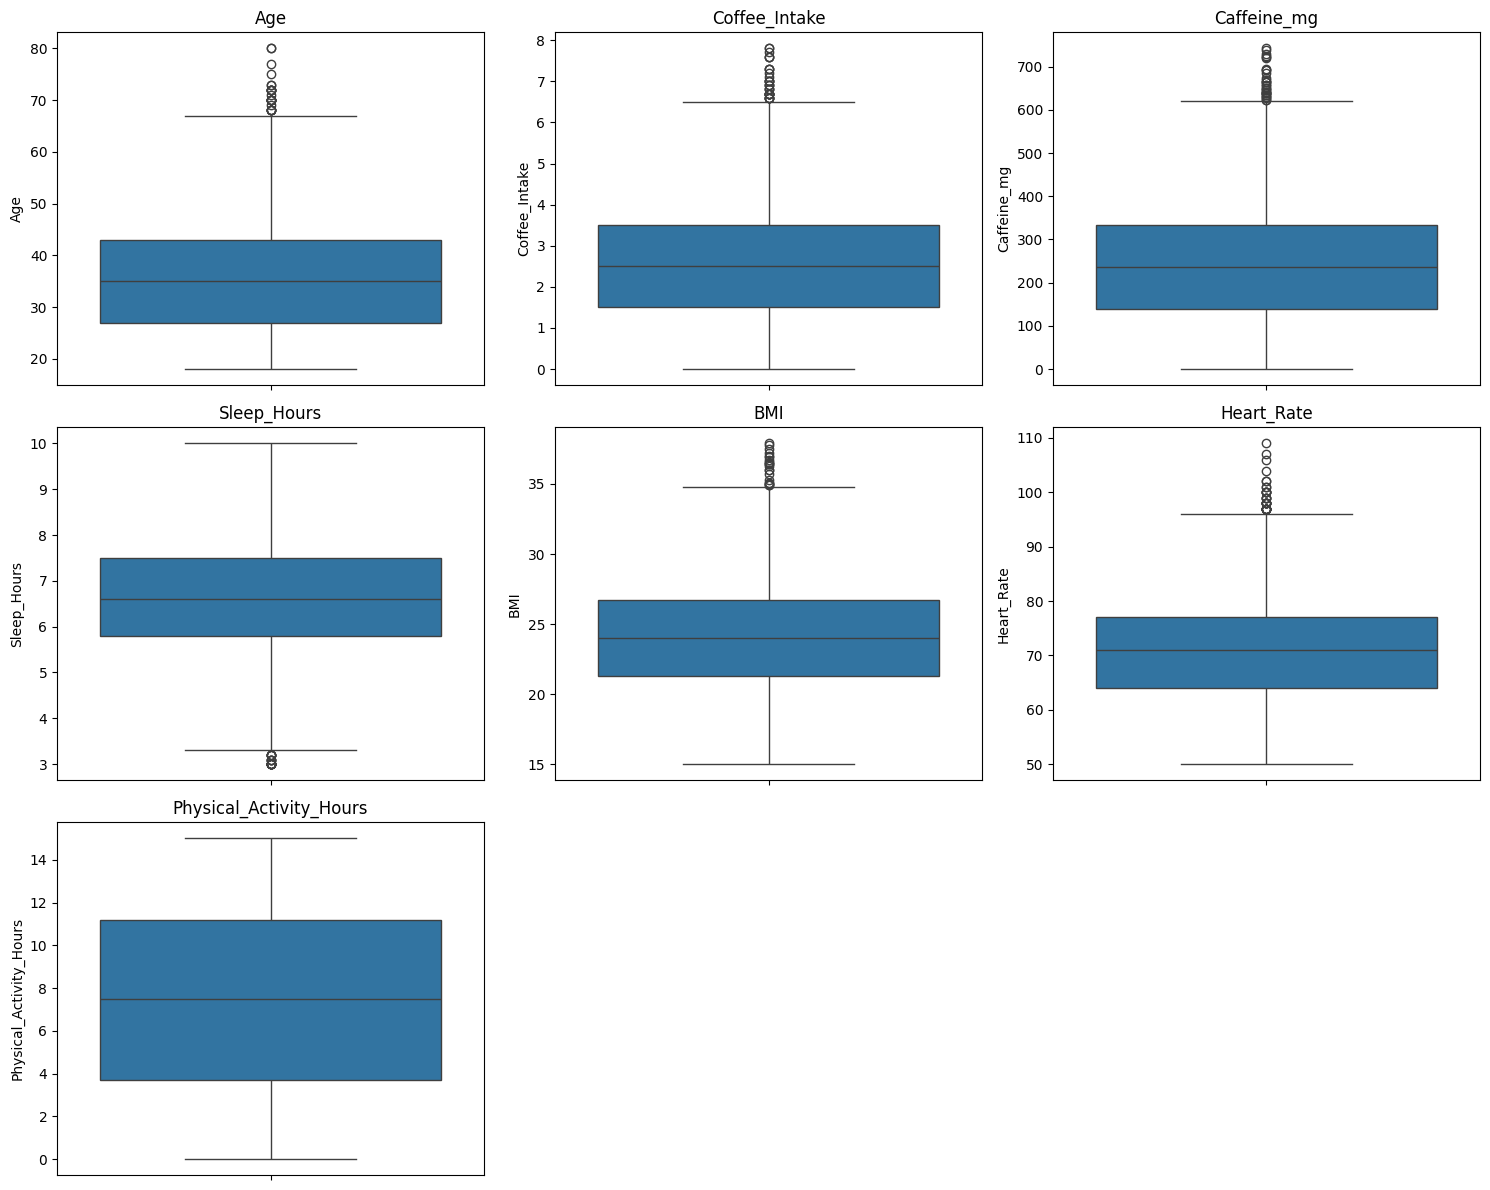

In [ ]:
# Grid com boxplots
import math

colunas = colunas_num.drop(columns=['Smoking', 'Alcohol_Consumption']).columns.to_list()

n_cols = 3
n_total = len(colunas)
n_rows = math.ceil(n_total / n_cols)

plt.figure(figsize=(5 * n_cols, 4 * n_rows))
for i, col in enumerate(colunas):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(y=df_train[col])
    plt.title(col)

plt.tight_layout()
plt.show()

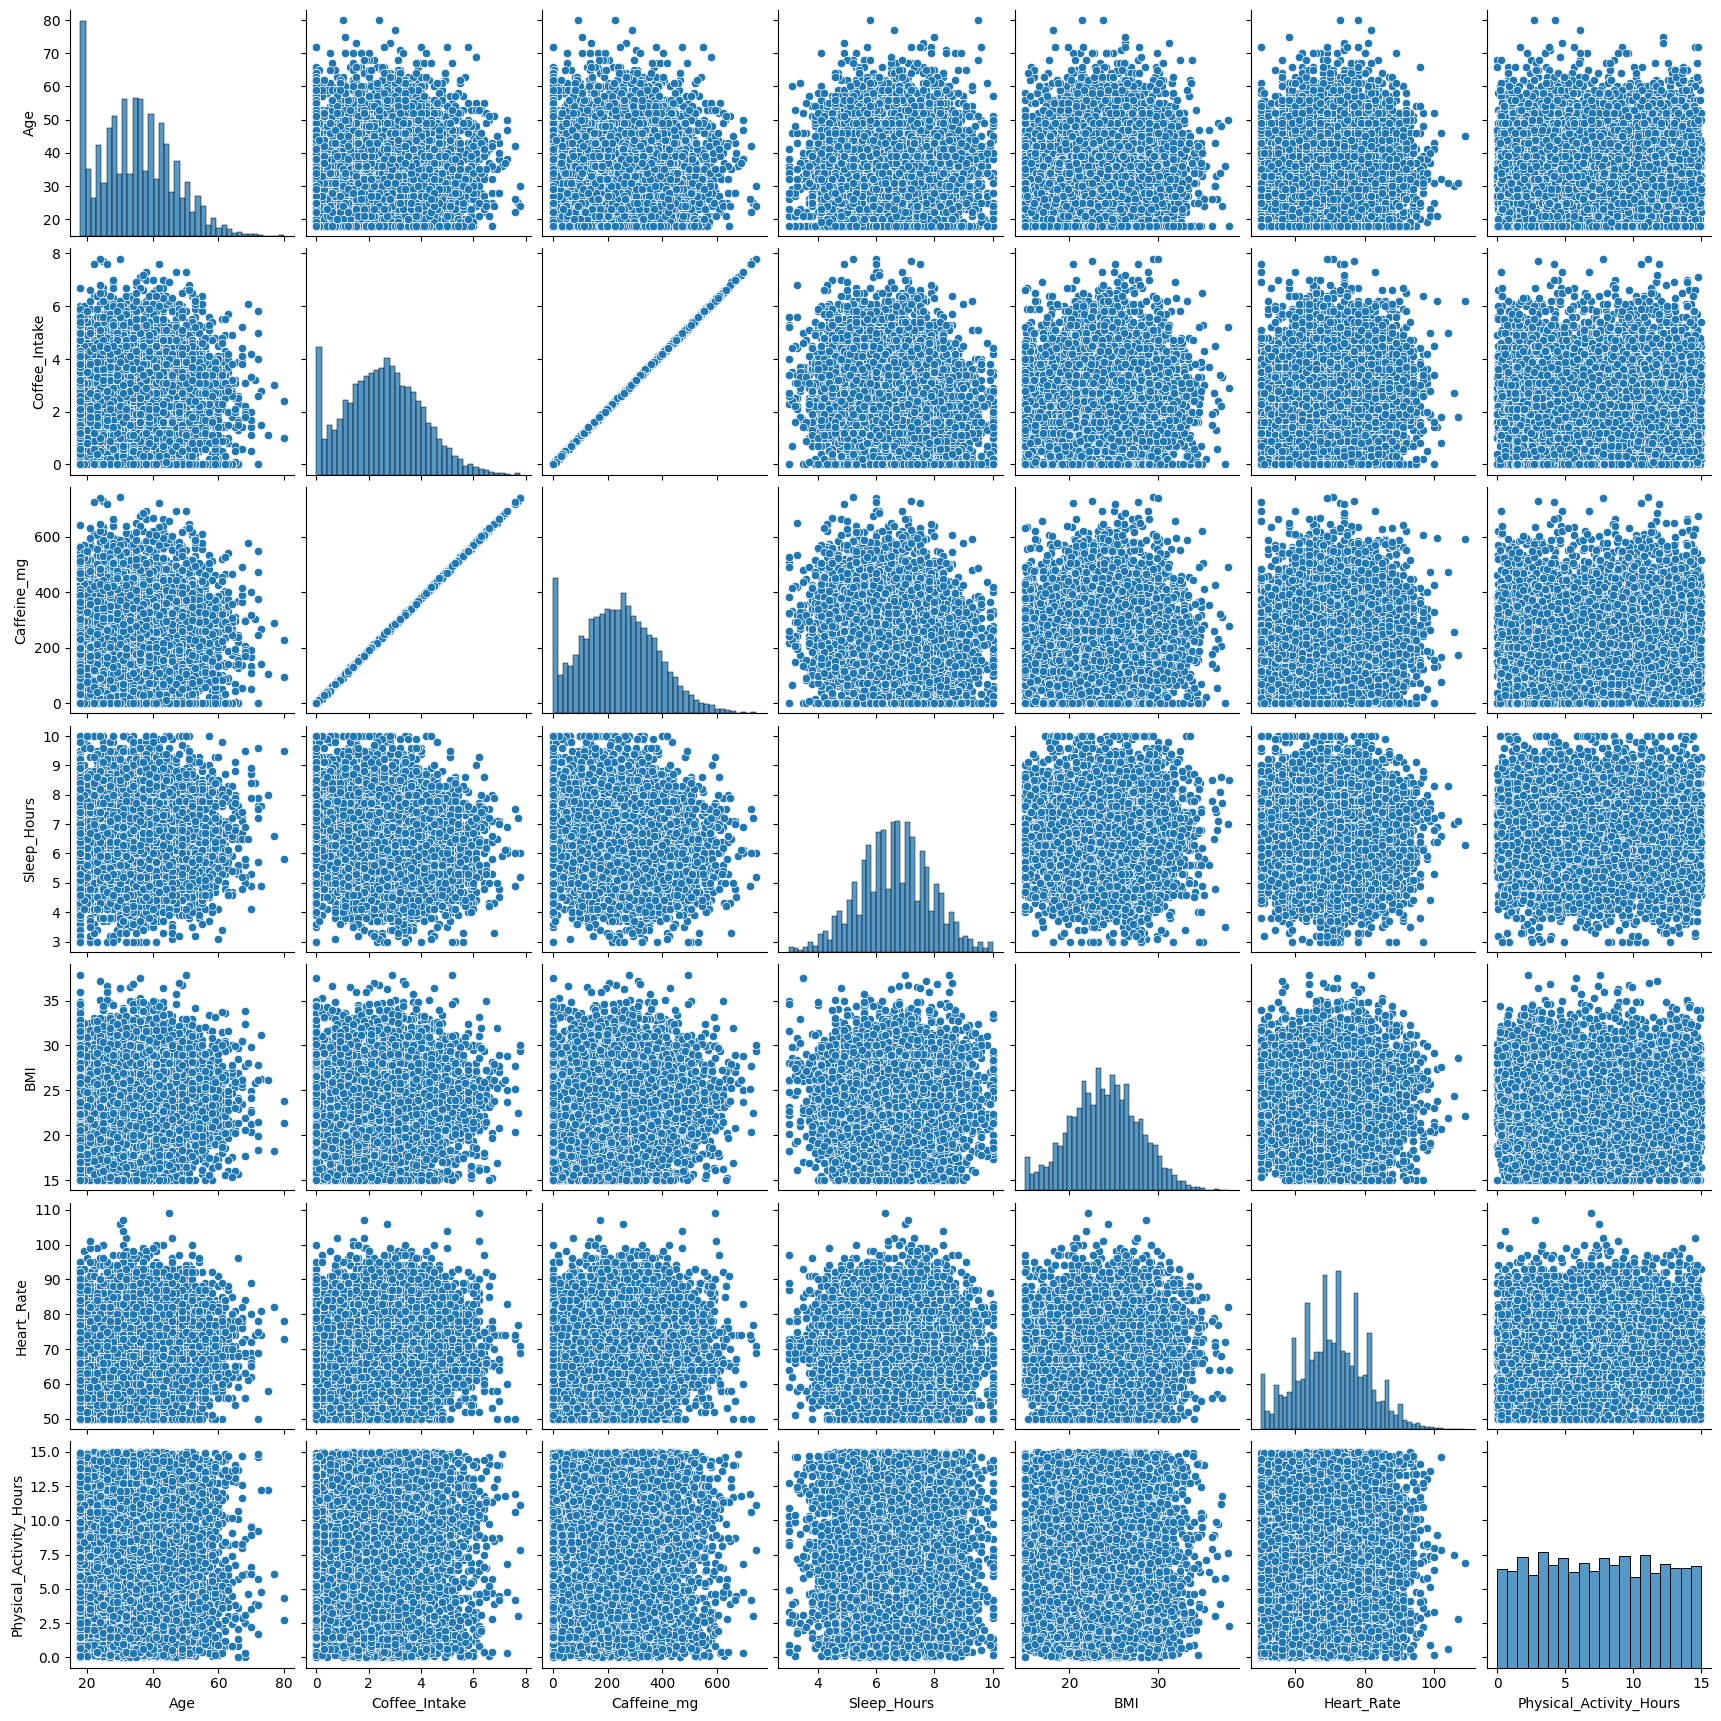

In [ ]:
# Dispersão 2 a 2, com a distribuição na diagonal principal
sns.pairplot(data=colunas_num.drop(columns=['Smoking', 'Alcohol_Consumption']))

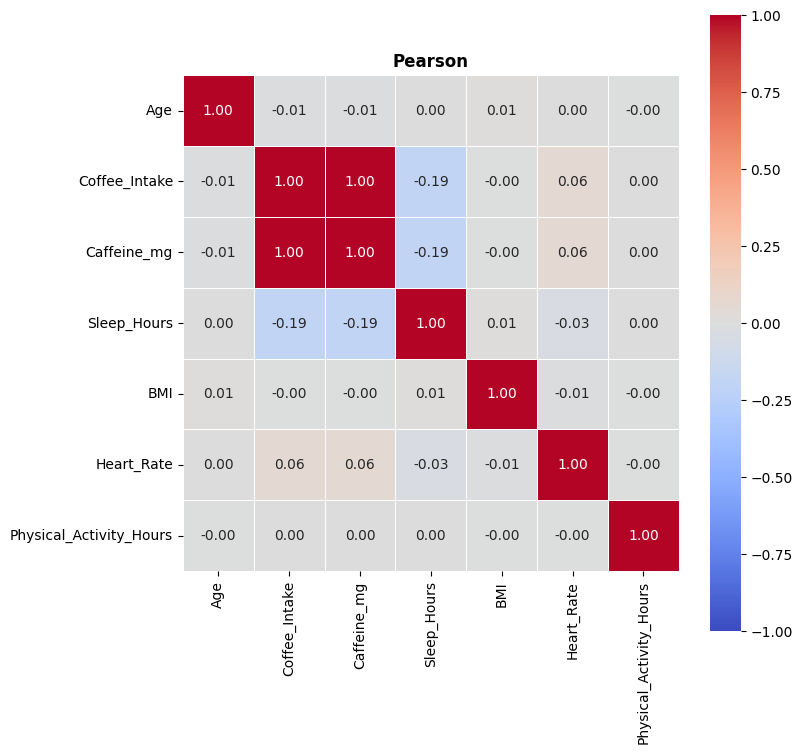

In [ ]:
# Heatmap da matriz de correlação
corr = df_train[colunas].corr()

plt.figure(figsize=(8,8))
sns.heatmap(corr, annot=True, fmt='.2f', square= True,
            linewidth=.5, cmap='coolwarm',vmin=-1, vmax=1)
plt.title('Pearson', fontweight='bold')
plt.show()

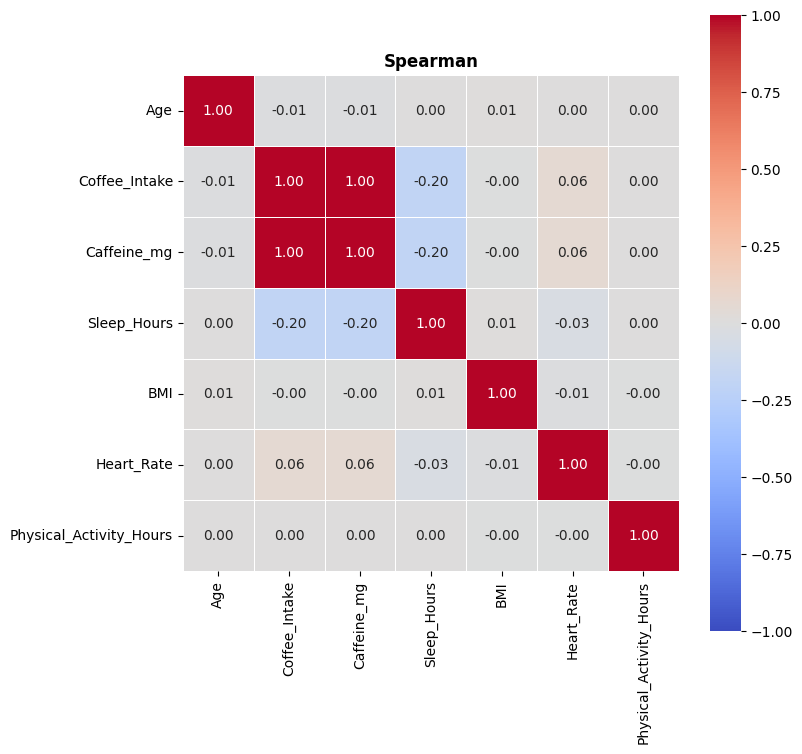

In [ ]:
corr = df_train[colunas].corr('spearman')

plt.figure(figsize=(8,8))
sns.heatmap(corr, annot=True, fmt='.2f', square= True,
            linewidth=.5, cmap='coolwarm',vmin=-1, vmax=1)
plt.title('Spearman', fontweight='bold')
plt.show()

Por enquanto não parecem existir pontos muito extremos, densidades estão relativamente próximas de uma normal (um pouco assimétricas à direita), comentários:
* Atividade física uniformemente distribuída
* Muitos 0's no Coffe_intake, o estudo inclui uma parcela de zero estrutural (pessoas que não tomam café)
* Muitas pessoas com 18 anos
* Relação perfeitamente linear entre Coffe_intake e 'Caffeine_mg' deve ser cuidada para não gerar multicolinearidade
* Pouca correlação em geral, fraca exceção negativa quanto a Sleep_Hours e dosagem de café.

#### Variáveis categóricas

In [ ]:
df_train.columns

Index(['ID', 'Age', 'Gender', 'Country', 'Coffee_Intake', 'Caffeine_mg',
       'Sleep_Hours', 'Sleep_Quality', 'BMI', 'Heart_Rate', 'Stress_Level',
       'Physical_Activity_Hours', 'Health_Issues', 'Occupation', 'Smoking',
       'Alcohol_Consumption'],
      dtype='object')

In [ ]:
# descritiva
cols_categoricas = ['Gender', 'Country', 'Sleep_Quality',
                    'Stress_Level', 'Health_Issues', 'Occupation']
colunas_cat = df_train[cols_categoricas]
colunas_cat.describe()

Gender Country Sleep_Quality Stress_Level Health_Issues Occupation
count     8000    8000          8000         8000          3277       8000
unique       3      20             4            3             3          5
top     Female  Canada          Good          Low          Mild     Office
freq      3997     430          4475         5554          2885       1674

In [ ]:
# conferindo as categorias
for c in colunas_cat:
    print(f"{c}: {df_train[c].unique()}")
    print()

Gender: ['Male' 'Female' 'Other']

Country: ['Spain' 'India' 'South Korea' 'UK' 'Brazil' 'Japan' 'Canada' 'USA'
 'Australia' 'Norway' 'Belgium' 'Sweden' 'Finland' 'France' 'Italy'
 'Mexico' 'Switzerland' 'China' 'Germany' 'Netherlands']

Sleep_Quality: ['Fair' 'Good' 'Excellent' 'Poor']

Stress_Level: ['Medium' 'Low' 'High']

Health_Issues: ['Mild' nan 'Moderate' 'Severe']

Occupation: ['Service' 'Other' 'Office' 'Healthcare' 'Student']



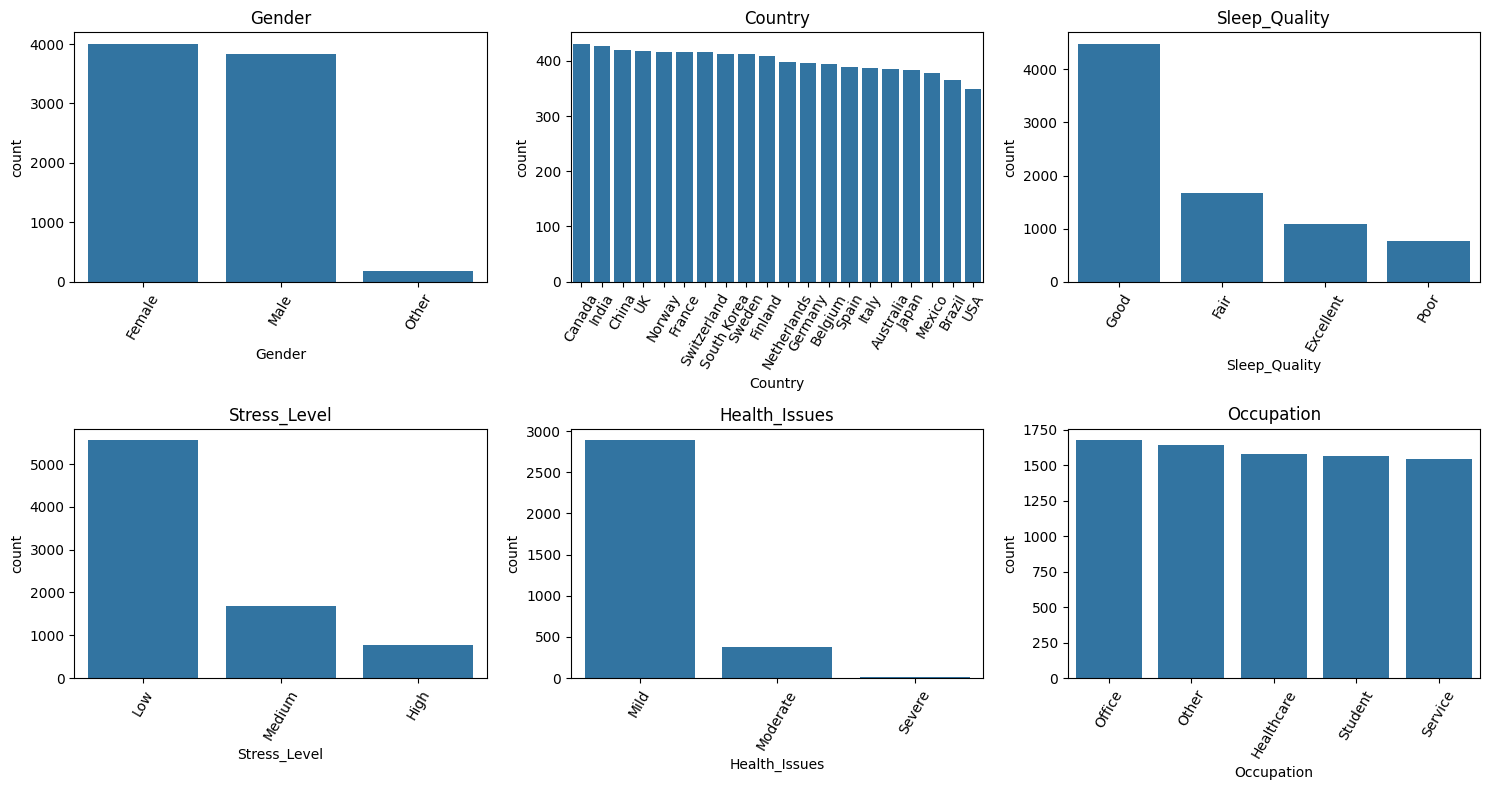

In [ ]:
# Grid com histogramas
n_cols = 3
n_total = len(cols_categoricas)
n_rows = math.ceil(n_total / n_cols)

plt.figure(figsize=(5 * n_cols, 4 * n_rows))

for i, col in enumerate(cols_categoricas):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.countplot(data=df_train, x=col, order=df_train[col].value_counts().index)
    plt.title(col)
    plt.xticks(rotation=60)

plt.tight_layout()
plt.show()

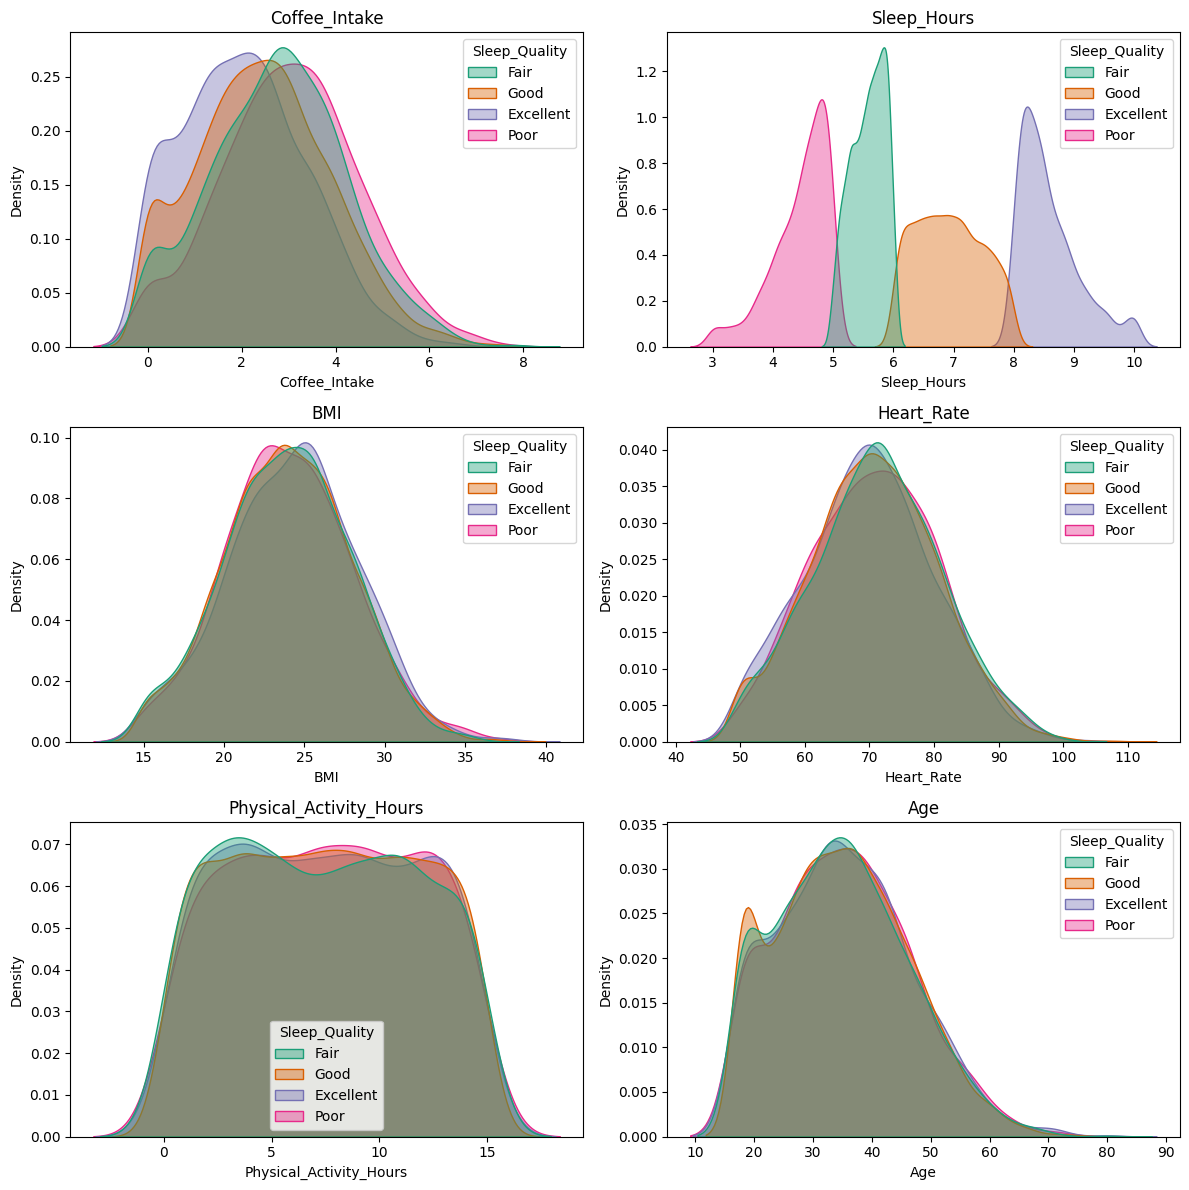

In [ ]:
# Grid com densidades das numéricas, separadas por alguma categoria
df_plot = df_train.copy()
df_plot['Health_Issues'] = df_plot['Health_Issues'].fillna('Missing')


cols_num = ['Coffee_Intake', 'Sleep_Hours', 'BMI', 'Heart_Rate', 'Physical_Activity_Hours','Age']

# hues e ordens
hues = {
    'Sleep_Quality': ['Fair', 'Good', 'Excellent', 'Poor'],
    'Stress_Level': ['Low', 'Medium', 'High'],
    'Health_Issues': ['Mild', 'Moderate', 'Severe', 'Missing']}

# grid 3x2
n_cols = 2
n_rows = math.ceil(len(cols_num) / n_cols)

plt.figure(figsize=(6 * n_cols, 4 * n_rows))

for i, col in enumerate(cols_num):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.kdeplot(data=df_plot, x=col, hue='Sleep_Quality', hue_order=hues['Sleep_Quality'],
                common_norm=False, fill=True, alpha=0.40, palette='Dark2')
    plt.title(col)
plt.tight_layout()
plt.show()

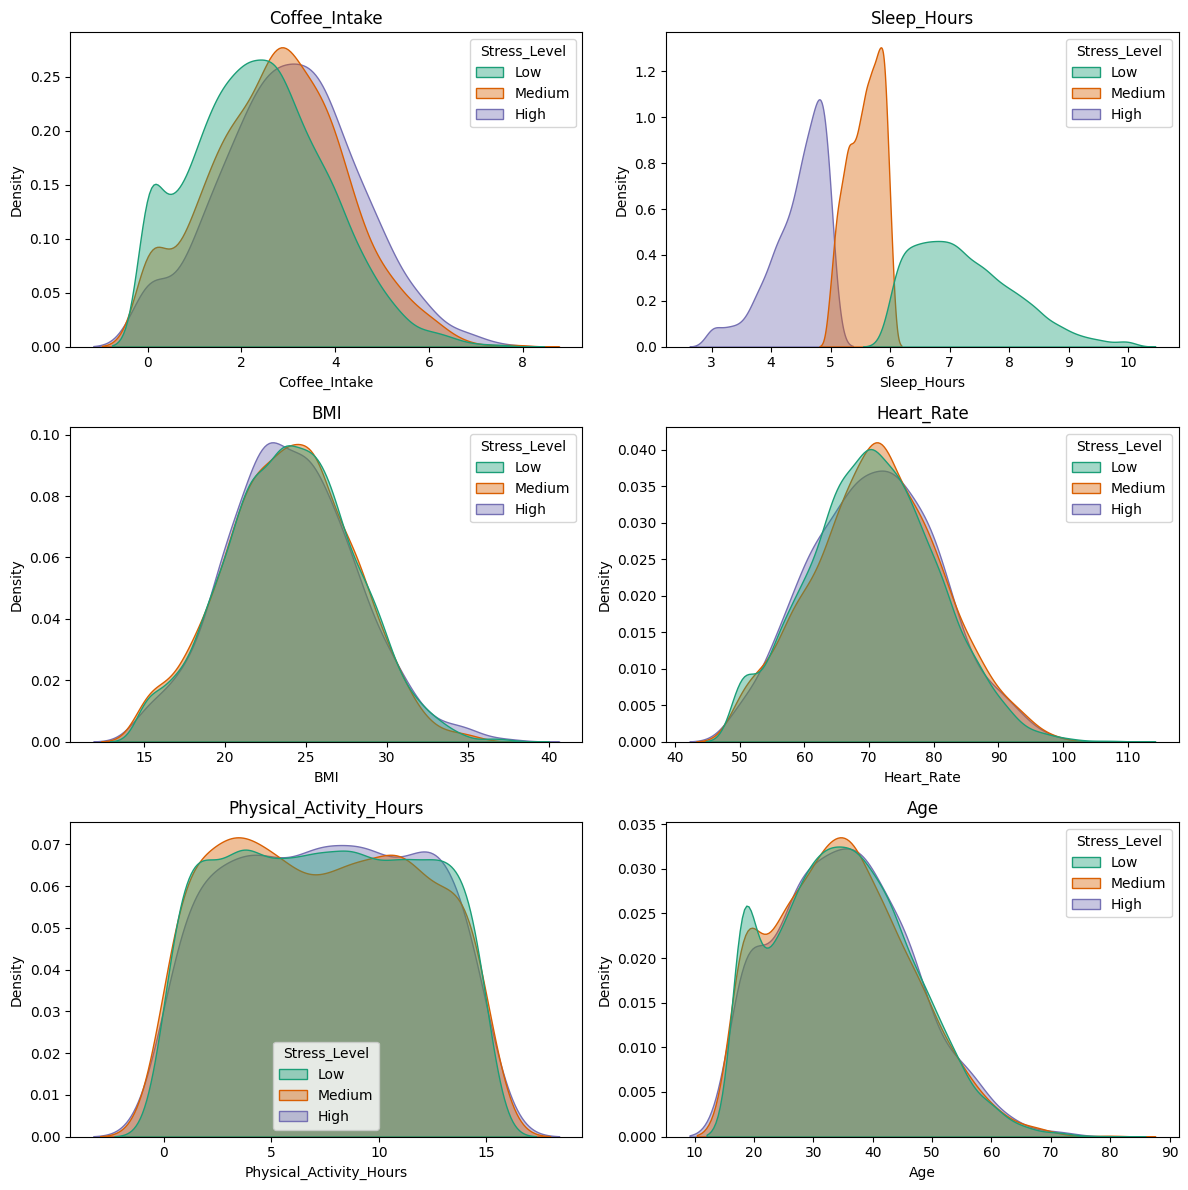

In [ ]:
# Repetindo para outras categorias. (clique para ver o código por extenso)
df_plot = df_train.copy()
df_plot['Health_Issues'] = df_plot['Health_Issues'].fillna('Missing')


cols_num = ['Coffee_Intake', 'Sleep_Hours', 'BMI', 'Heart_Rate', 'Physical_Activity_Hours','Age']

# hues e ordens
hues = {
    'Sleep_Quality': ['Fair', 'Good', 'Excellent', 'Poor'],
    'Stress_Level': ['Low', 'Medium', 'High'],
    'Health_Issues': ['Mild', 'Moderate', 'Severe', 'Missing']}

# grid 3x2
n_cols = 2
n_rows = math.ceil(len(cols_num) / n_cols)

plt.figure(figsize=(6 * n_cols, 4 * n_rows))

for i, col in enumerate(cols_num):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.kdeplot(data=df_plot, x=col, hue='Stress_Level', hue_order=hues['Stress_Level'],
                common_norm=False, fill=True, alpha=0.40, palette='Dark2')
    plt.title(col)
plt.tight_layout()
plt.show()

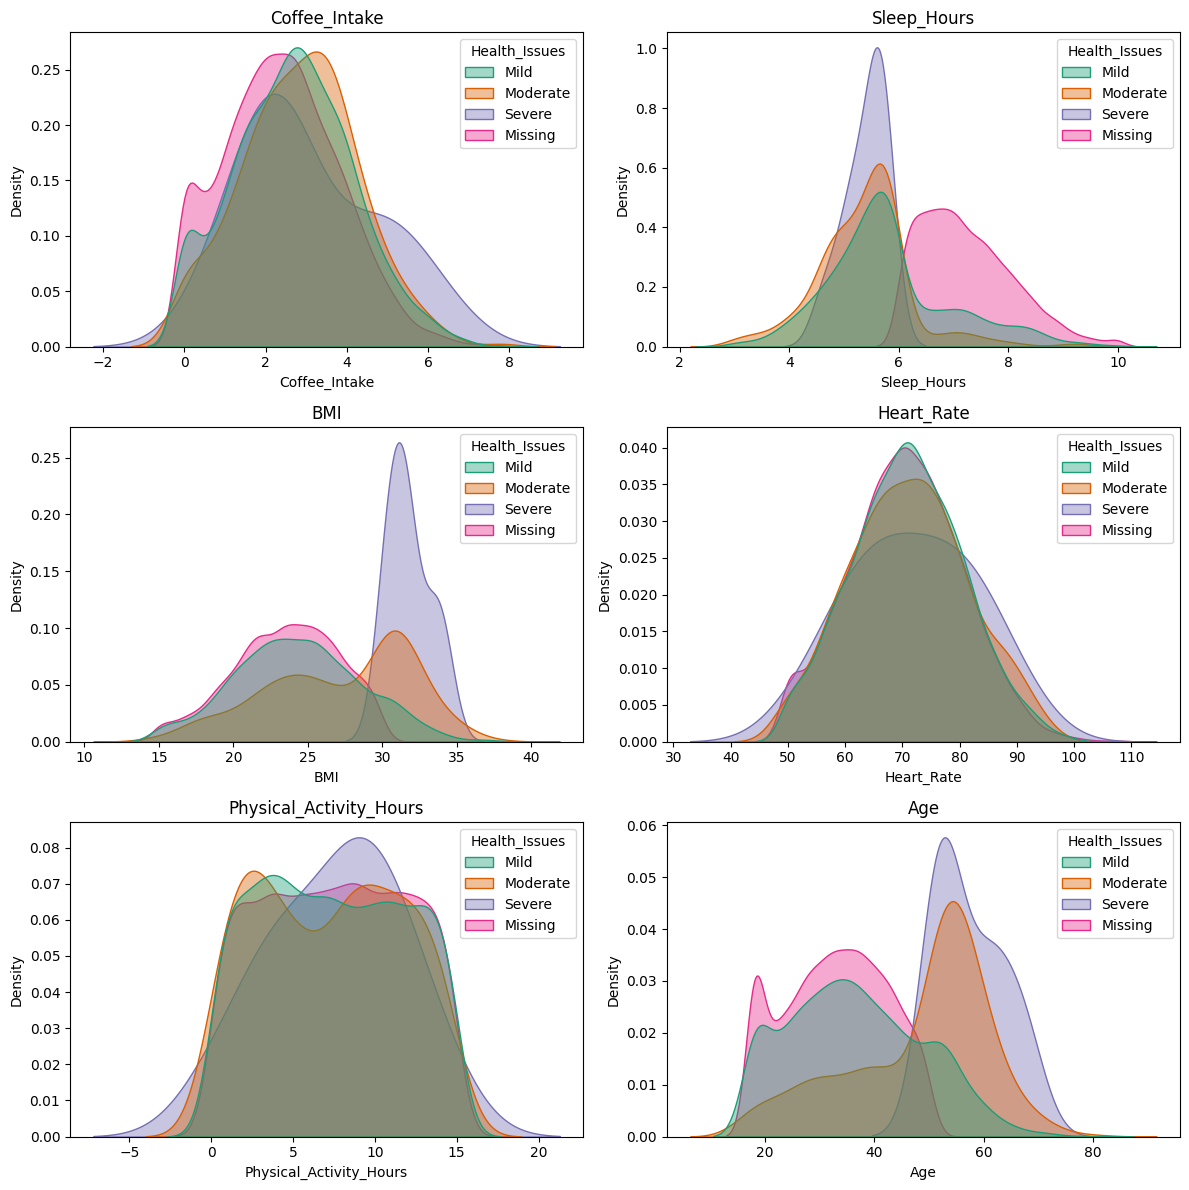

In [ ]:

df_plot = df_train.copy()
df_plot['Health_Issues'] = df_plot['Health_Issues'].fillna('Missing')


cols_num = ['Coffee_Intake', 'Sleep_Hours', 'BMI', 'Heart_Rate', 'Physical_Activity_Hours','Age']

# hues e ordens
hues = {
    'Sleep_Quality': ['Fair', 'Good', 'Excellent', 'Poor'],
    'Stress_Level': ['Low', 'Medium', 'High'],
    'Health_Issues': ['Mild', 'Moderate', 'Severe', 'Missing']}

# grid 3x2
n_cols = 2
n_rows = math.ceil(len(cols_num) / n_cols)

plt.figure(figsize=(6 * n_cols, 4 * n_rows))

for i, col in enumerate(cols_num):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.kdeplot(data=df_plot, x=col, hue='Health_Issues', hue_order=hues['Health_Issues'],
                common_norm=False, fill=True, alpha=0.40, palette='Dark2')
    plt.title(col)
plt.tight_layout()
plt.show()

Relações marcantes:
* Sleep_Hours e Sleep_Quality
* Sleep_Hours e Stress_level
* Sleep_Hours e Health_Issues
* BMI e Health_Issues
* Age e Health_Issues

# Tratamento/ Pré-processamento
Após analisar os dados, use esta seção para aplicar os tratamentos necessários. A seguir algumas sugestões:

* Arrumar formato (datatype), principalmente aqueles sobre Tempo
* Tratamento dos dados faltantes
* Outliers
* Corrigir unidades de medida
* Arrumar nomes e outros problemas com strings
* Encoding das variáveis categóricas
* Padronização das variáveis numéricas
* etc

**ATENÇÃO!** essa parte é crucial não só para performance do modelo quanto para validade de todo o processo. Toda alteração no conjunto de treino deve ser espelhada no Teste para garantir a consistência.

EXEMPLO 1: A unidade de medida de uma feature estava errada: altere tanto no treino quanto no teste

EXEMPLO 2: Se padronizar os dados na base de treino (subtraindo a média de cada variável e dividindo por seu desvio padrão), padronize também a base de teste (usando a média e o dp calculados **no treino**, do contrário você estará vazando dados)

(nesses casos você pode mexer no teste, você não está olhando para os dados no teste e nem usando as informações contidas nele para análise nem treinamento)

#### Normalização

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8000 entries, 9254 to 7270
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       8000 non-null   int64  
 1   Age                      8000 non-null   int64  
 2   Gender                   8000 non-null   object 
 3   Country                  8000 non-null   object 
 4   Coffee_Intake            8000 non-null   float64
 5   Caffeine_mg              8000 non-null   float64
 6   Sleep_Hours              8000 non-null   float64
 7   Sleep_Quality            8000 non-null   object 
 8   BMI                      8000 non-null   float64
 9   Heart_Rate               8000 non-null   int64  
 10  Stress_Level             8000 non-null   object 
 11  Physical_Activity_Hours  8000 non-null   float64
 12  Health_Issues            3277 non-null   object 
 13  Occupation               8000 non-null   object 
 14  Smoking                  8

In [ ]:
num_cols = df_train.drop('Sleep_Hours', axis=1).select_dtypes(include=np.number).columns

std_scaler = RobustScaler().fit(df_train[num_cols])


df_train[num_cols] = std_scaler.transform(df_train[num_cols])
df_test[num_cols] = std_scaler.transform(df_test[num_cols])

#df_train_std = pd.Datastd_scaler.transform(df_train.select_dtypes(include=np.number)).concat(df_train.select_dtypes(exclude=np.number))
#df_test_std = std_scaler.transform(df_test.select_dtypes(include=np.number)).concat(df_test.select_dtypes(exclude=np.number))

#### OneHotEncoding para categóricas
Para incluir variáveis categóricas no modelo de regressão vamos usar variáveis _dummy_ (0/1)

In [ ]:
cols_categoricas = ['Gender', 'Sleep_Quality',
                    'Stress_Level', 'Occupation']

# One-hot encoding completo
df_train_encoded = pd.get_dummies(df_train, columns=cols_categoricas, drop_first=False)
df_test_encoded = pd.get_dummies(df_test, columns=cols_categoricas, drop_first=False)

# Garantir consistência de colunas entre treino e teste
df_test_encoded = df_test_encoded.reindex(columns=df_train_encoded.columns, fill_value=0)

# Engenharia de Features
A performance dos modelos pode melhorar significativamente com a adição de combinações ou transformações de variáveis já existentes. Caso tenha identificado alguma relação na etapa de análise, tente expressar isso aqui com uma nova coluna!

# Seleção de Features
Por vezes usar um conjunto de features de alta dimensão e com variáveis pouco relevantes pode gerar "mais ruído que sinal", sendo assim, você pode tentar treinar o modelo apenas com as variáveis que julgar mais relevantes (sugestão: selectKbest).

# Treinamento com validação cruzada

### Especificando a variável resposta e o conjunto de variáveis explicativas

In [ ]:
# Estou ignorando 'Health_Issues' devido aos NaN´s. Caso deseje tratar e usar aqui não esqueça de
# incluir no X (tire Health_issues do drop columns)

X_train = df_train_encoded.drop(columns=['Sleep_Hours','Health_Issues', 'Coffee_Intake', 'Country'])
y_train = df_train_encoded['Sleep_Hours']

X_test = df_test_encoded.drop(columns=['Sleep_Hours', 'Health_Issues', 'Coffee_Intake', 'Country'])
y_test = df_test_encoded['Sleep_Hours']

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(8000, 23)
(8000,)
(2000, 23)
(2000,)


In [ ]:
X_train.head()

ID     Age  Caffeine_mg       BMI  Heart_Rate  \
9254  0.849374  0.1250     0.875454 -1.111111    1.153846   
1561 -0.691537 -0.5625    -1.229372  0.796296    0.307692   
1670 -0.669705 -0.1875     0.161910  0.629630   -0.153846   
6087  0.215023 -1.0625    -0.146860 -1.425926    0.923077   
6669  0.331597  0.5000     0.073690  0.259259   -0.230769   

      Physical_Activity_Hours  Smoking  Alcohol_Consumption  Gender_Female  \
9254                -0.680000      0.0                  1.0          False   
1561                 0.440000      0.0                  0.0          False   
1670                 0.146667      0.0                  0.0          False   
6087                 0.186667      0.0                  1.0          False   
6669                -0.546667      0.0                  0.0           True   

      Gender_Male  ...  Sleep_Quality_Good  Sleep_Quality_Poor  \
9254         True  ...               False               False   
1561         True  ...               False               False   
1670         True  ...                True               False   
6087         True  ...               False               False   
6669        False  ...               False               False   

      Stress_Level_High  Stress_Level_Low  Stress_Level_Medium  \
9254              False             False                 True   
1561              False             False                 True   
1670              False              True                False   
6087              False              True                False   
6669              False              True                False   

      Occupation_Healthcare  Occupation_Office  Occupation_Other  \
9254                  False              False             False   
1561                  False              False              True   
1670                  False               True             False   
6087                  False              False              True   
6669                  False               True             False   

      Occupation_Service  Occupation_Student  
9254                True               False  
1561               False               False  
1670               False               False  
6087               False               False  
6669               False               False  

[5 rows x 23 columns]

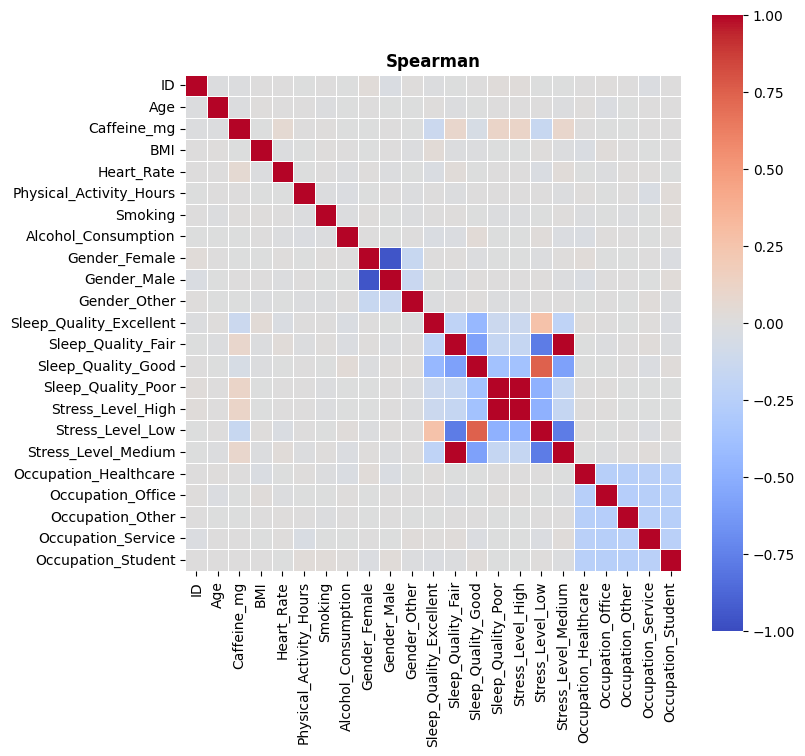

In [ ]:
corr = X_train.corr('spearman')

plt.figure(figsize=(8,8))
sns.heatmap(corr, annot=False, square= True,
            linewidth=.5, cmap='coolwarm',vmin=-1, vmax=1)
plt.title('Spearman', fontweight='bold')
plt.show()

### Métrica de erro usual da regressão: Erro Quadrático Médio (EQM ou MSE em inglês)
## $$EQM = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y_i})^2$$
#### $$y_i: \text{target da base de teste}, \quad \hat{y_i}: \text{target da predição do modelo}$$
## O objetivo é **minimizar** este valor!

## Modelo
Busque outros modelos mais sofisticados para regressão

In [ ]:
modelo = LinearRegression()

##  Cross-Validation
Especifique o modelo, conjunto de features a serem usadas, num de folds (5 ou 10).
A métrica de erro deve ser o EQM mesmo

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html

In [ ]:
scores = cross_val_score(modelo, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
scores_medio = -scores.mean()
scores_medio

np.float64(0.24044676326613143)

In [ ]:
# alternativa
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error

modelo = LinearRegression()                                      # seleciona o modelo
kf = KFold(n_splits=5, shuffle=True, random_state=42)            # 5 folds
y_pred_cv = cross_val_predict(modelo, X_train, y_train, cv=kf)   # Treina em cada fold

# Avalia cada fold
r2_cv = r2_score(y_train, y_pred_cv)
mse_cv = mean_squared_error(y_train, y_pred_cv)   # squared para MSE

print("Treino: ")
print("R² médio:", r2_cv)
print("MSE médio:", mse_cv)

Treino: 
R² médio: 0.8402604645658522
MSE médio: 0.24005945892116234


# Treino final
O Cross-Validation separa o treino em k-folds, sendo um deles chamado de validação e o resto "treino". Uma vez que julgamos o modelo adequado, vamos realizar o treino novamente (agora com todo o conjunto de treino (ou seja, "treino"+validação"):

In [ ]:
# Treinar modelo final em todo o treino
modelo_final = LinearRegression()
modelo_final.fit(X_train, y_train)

# Prever no treino (opcional, só para conferir ajuste)
y_pred_train = modelo_final.predict(X_train)

# Previsão no Teste

In [ ]:
# Só agora usamos o conjunto de teste
# Prever usando o X_test
y_pred_test = modelo_final.predict(X_test)

# Avaliar
from sklearn.metrics import mean_squared_error, r2_score

print("Treino final:")
print("R²:", r2_score(y_train, y_pred_train))
print("MSE:", mean_squared_error(y_train, y_pred_train))

print("\nTeste final:")
print("R²:", r2_score(y_test, y_pred_test))
print("MSE:", mean_squared_error(y_test, y_pred_test))


Treino final:
R²: 0.8408714994109815
MSE: 0.23914118471994453

Teste final:
R²: 0.8378605776497735
MSE: 0.2357719502278433


### Agora é com você! tente obter um MSE<0.2376

## SHAP :)

In [ ]:
explainer = shap.LinearExplainer(modelo_final, X_train)
shap_values = explainer(X_train)

In [ ]:
shap_values

.values =
array([[0.0025161762947965897, -1.1815498808472057e-06,
        -0.04448858706306248, ..., 0.002634270648167582,
        -0.003270075744061374, -0.0011053644309492344],
       [-0.002080013260487527, 0.0003237446673521341,
        0.05759771688232128, ..., -0.012000566286096763,
        0.0006697745499884743, -0.0011053644309492344],
       [-0.0020148911154822015, 0.00014651218522505338,
        -0.009880927318263998, ..., 0.002634270648167582,
        0.0006697745499884743, -0.0011053644309492344],
       ...,
       [0.00020762612690138258, 0.0003237446673521341,
        -0.04768507636312751, ..., -0.012000566286096763,
        0.0006697745499884743, -0.0011053644309492344],
       [-0.0024988263214850786, -1.1815498808472057e-06,
        0.05009729317035767, ..., 0.002634270648167582,
        0.0006697745499884743, -0.0011053644309492344],
       [0.0013308337655253445, 0.000560054643521575,
        -0.018715319005845273, ..., 0.002634270648167582,
        -0.003270075744

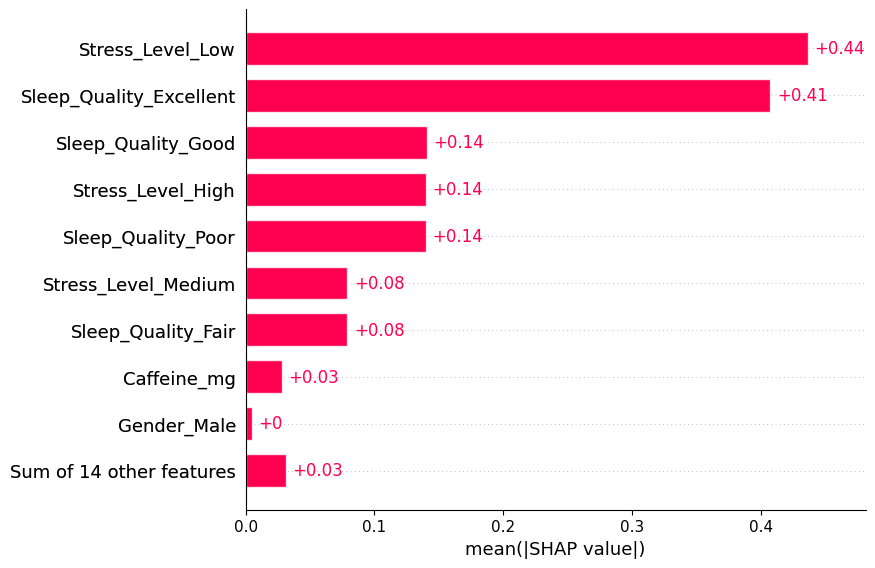

In [ ]:
shap.plots.bar(shap_values, show=True)

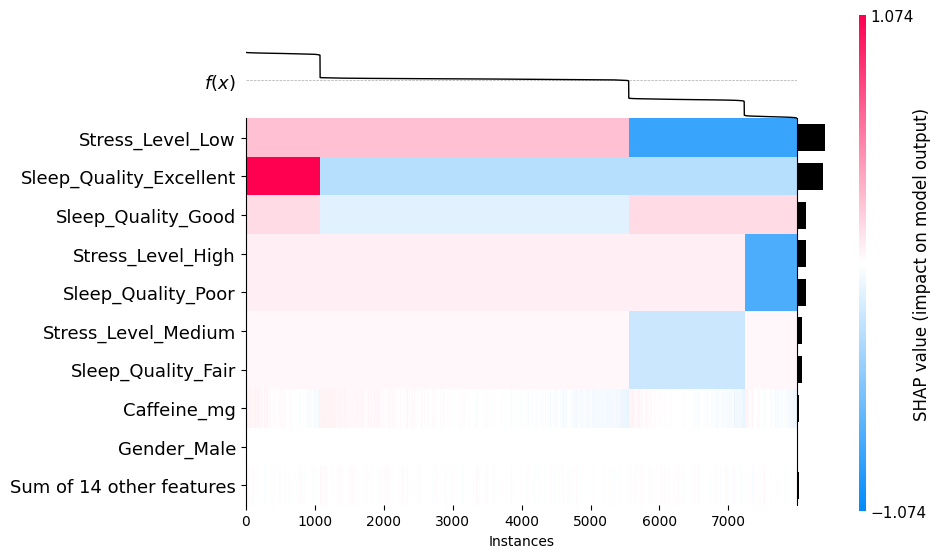

<Axes: xlabel='Instances'>

In [ ]:
shap.plots.heatmap(shap_values, instance_order=shap_values.sum(1))

In [ ]:
X_train.head()

ID     Age  Caffeine_mg       BMI  Heart_Rate  \
9254  0.849374  0.1250     0.875454 -1.111111    1.153846   
1561 -0.691537 -0.5625    -1.229372  0.796296    0.307692   
1670 -0.669705 -0.1875     0.161910  0.629630   -0.153846   
6087  0.215023 -1.0625    -0.146860 -1.425926    0.923077   
6669  0.331597  0.5000     0.073690  0.259259   -0.230769   

      Physical_Activity_Hours  Smoking  Alcohol_Consumption  Gender_Female  \
9254                -0.680000      0.0                  1.0          False   
1561                 0.440000      0.0                  0.0          False   
1670                 0.146667      0.0                  0.0          False   
6087                 0.186667      0.0                  1.0          False   
6669                -0.546667      0.0                  0.0           True   

      Gender_Male  ...  Sleep_Quality_Good  Sleep_Quality_Poor  \
9254         True  ...               False               False   
1561         True  ...               False               False   
1670         True  ...                True               False   
6087         True  ...               False               False   
6669        False  ...               False               False   

      Stress_Level_High  Stress_Level_Low  Stress_Level_Medium  \
9254              False             False                 True   
1561              False             False                 True   
1670              False              True                False   
6087              False              True                False   
6669              False              True                False   

      Occupation_Healthcare  Occupation_Office  Occupation_Other  \
9254                  False              False             False   
1561                  False              False              True   
1670                  False               True             False   
6087                  False              False              True   
6669                  False               True             False   

      Occupation_Service  Occupation_Student  
9254                True               False  
1561               False               False  
1670               False               False  
6087               False               False  
6669               False               False  

[5 rows x 23 columns]